In [1271]:
import numpy as np
import pickle
import numpy.matlib
import matplotlib.pyplot as plt
# didnt work ??? import functions.py.ipynb as f

# d = 3072
# k = 10
# n = 10000

In [1494]:
# Loades an entire batch
def LoadBatch(filename):
	""" Copied from the dataset website """ 
	with open('Datasets/'+filename, 'rb') as fo:
		dict = pickle.load(fo, encoding='bytes') 
	return dict

def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def ComputeGradsNumSlow(X, Y, P, W, b, lamda, h):
	""" Converted from matlab code """
	no 	= 	W.shape[0]
	d 	= 	X.shape[0]

	grad_W = np.zeros(W.shape);
	grad_b = np.zeros((no, 1));
	
	for i in range(len(b)):
		b_try = np.array(b)
		b_try[i] -= h
		c1 = ComputeCost(X, Y, W, b_try, lamda)

		b_try = np.array(b)
		b_try[i] += h
		c2 = ComputeCost(X, Y, W, b_try, lamda)

		grad_b[i] = (c2-c1) / (2*h)

	for i in range(W.shape[0]):
		for j in range(W.shape[1]):
			W_try = np.array(W)
			W_try[i,j] -= h
			c1 = ComputeCost(X, Y, W_try, b, lamda)

			W_try = np.array(W)
			W_try[i,j] += h
			c2 = ComputeCost(X, Y, W_try, b, lamda)

			grad_W[i,j] = (c2-c1) / (2*h)

	return [grad_W, grad_b]

##############################################################

def ReadData(filename):
    data_batch = LoadBatch(filename)
    
    # get pixel data
    # divide by 255 for single format
    # Maybe have to transpose
    pixel_data = data_batch[b'data'] #/255
    # labels for each image
    labels = data_batch[b'labels']
    # one-hot rep. of labels
    # T -> roterar
    one_hot = np.eye(10)[labels].T
    print(one_hot.shape)
    return pixel_data, one_hot, labels

def GetMeanAndStd(data):  
    print(data)
    # Kanske ändra
    mean = np.mean(data, 0)
    std = np.std(data, 0) # nånting saknas 
    return mean, std

# input trainings data mean std
def Normalize(train, validation, test, mean, std):
        # convert to floar
        train = np.float64(train)
        validation = np.float64(validation)
        test = np.float64(test)
        
        # Lurigt
        train -= mean 
        train /= std
    
        validation -= mean
        validation /= std
        
        test -= mean
        test /= std
        
        return train.T, validation.T, test.T
        
        #train = train    
def GetWeightAndBias(X, Y):
    W_size = X.shape
    b_size = Y.shape
    # Random seed????
    # loc = mean, scale = std
    np.random.seed(400)
    W = np.random.normal(loc=0.0, scale=0.01, size=(10, 3072))
    b = np.random.normal(loc=0.0, scale=0.01, size=(b_size[0], 1))
    print("W", W)
    print("b", b)
    return W, b


def EvaluateClassifier(X, W, b):
   # print(W.shape)
  #  print(X.shape)
    s = np.dot(W, X) + b
    # Softmax returns each probability for each class label
    P = softmax(s)
    return P

# 1. regularization term: calculate lambda * sum(W^2 ij)
# 2. sum it with l_cross + regularization term -> for each x,y in D
# 3. Multiply everything with 1 / length of D
def ComputeCost(X, Y, W, b, lambd):
    #div_D_length = 1 / len(X) * 2
   # print(div_D_length)

    # calculate P using softmax
    P = EvaluateClassifier(X, W, b)
    # Calculate cross-entropy-loss
    l_cross = -np.sum(np.multiply(Y, np.log(P)))
    # calculate regularization term
    reg_term = lambd * np.sum(np.square(W))
    # calculate total cost function
    
    # OBS: |D| is it the length of y+x or only x?
    J = (1 / len(X[1])) * l_cross + reg_term
    
    return J

def ComputeAccuracy(X, y, W, b):

    P = EvaluateClassifier(X,W,b)
    print("Output softmax: ", np.max(P))
    acc = np.mean(y == np.argmax(P, axis=0))
    
    return acc
    
# Tried to do from last slide of L3
# Forward pass is already done since we have already calculated P
def ComputeGradients(X, Y, P, W, lambd):

    n_b = X.shape[1]
    
    # Backward pass
    G_batch = -(Y - P)
    # Backward pass + reg term
    # LCROSS IS WHERE?! see (11) and (10)
    grad_W = 1 / n_b * np.dot(G_batch, X.T) + 2 * lambd * W
    # Backward pass for 
    grad_b = 1 / n_b * np.dot(G_batch, np.ones(shape=(n_b, 1)))
    return grad_W, grad_b

def CompareGradients(X, Y, W, b, lambd, h):
    P = EvaluateClassifier(X, W, b)
    grad_W_a, grad_b_a = ComputeGradients(X, Y, P, W, lambd)
    grad_W_n, grad_b_n = ComputeGradsNumSlow(X, Y, P, W, b, lambd, h)
    
    
    w_rel_error = np.sum(np.abs(grad_W_a - grad_W_n)) / np.maximum(0.0001, np.sum(np.abs(grad_W_a) + np.abs(grad_W_n)))
    b_rel_error = np.sum(np.abs(grad_b_a - grad_b_n)) / np.maximum(0.0001, np.sum(np.abs(grad_b_a) + np.abs(grad_b_n)))


    #print("abs_difference", abs_difference)
   # denominator = np.maximum(0.00001, np.sum(np.abs(g_W) + np.abs(ng_W)))
   # print("denominator ", denominator)
   # kvot = abs_difference / denominator
 #   print(kvot)

    if w_rel_error < 1e-6 and b_rel_error < 1e-6:
        print("ok")
    else:
        print("gradient difference too high")

# Optimization of parameters with mini b GD
# Differs from Batch Gradient Descent and Stochastic GD
def MiniBatchGD(X, Y, GDparams, W, b, lambd):
    
    cost_list = []
    n_batch = GDparams['n_batch']
    epochs = GDparams['n_epochs']
    learning_rate = GDparams['eta']

    n = X.shape[1]
    
    for i in range(epochs):
        for j in range(n // n_batch):
            j_start = j*n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            # Random subset of train and corr. labels
            XBatch = X[:, inds]
            YBatch = Y[:, inds]

            # Fwd pass on mini batch
            P = EvaluateClassifier(XBatch, W, b)
            # Backward pass on mini batch
            grad_W, grad_b = ComputeGradients(XBatch, YBatch, P, W, lambd)
            # Update parameters for next iteration
            W_t1 = W - learning_rate * grad_W 
            b_t1 = b - learning_rate * grad_b
            W = W_t1
            b = b_t1
            
        # Append cost to list for each iteration
        cost_list.append(ComputeCost(XBatch, YBatch, W_t1, b_t1, lambd))
     
    return cost_list

In [1495]:
# Read data
X_train, Y_train, y_test = ReadData('data_batch_1')
X_val_train, Y_val_train, y_val_test = ReadData('data_batch_2')
X_test_train, Y_test_train, y_test_test = ReadData('test_batch')

# Gets mean and std of training data
X_mean, X_std = GetMeanAndStd(X_train)

(10, 10000)
(10, 10000)
(10, 10000)
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]


In [1496]:
# Normalize all data w.r.t. mean and std of training data
X_train_normalized, X_val_train_normalized, X_test_train_normalized = Normalize(X_train, X_val_train, X_test_train, X_mean, X_std)

In [1497]:
# Create model params W and b
# W = Weight, b = bias
W, b = GetWeightAndBias(X_train_normalized, Y_train)

W [[-0.01130571  0.006962   -0.00432293 ...  0.01918122  0.02090237
  -0.01208497]
 [-0.00094515  0.00190318  0.00156382 ...  0.01256111  0.003769
   0.00958823]
 [ 0.00497479 -0.00458464 -0.00532068 ... -0.01533887 -0.01901909
   0.00065717]
 ...
 [-0.00231262  0.00527368  0.00365814 ...  0.00194691 -0.00416015
   0.01300918]
 [-0.00505378  0.01229643 -0.00737665 ... -0.00932474 -0.00219402
  -0.01213368]
 [ 0.01665402 -0.0037449  -0.00115744 ...  0.00125636  0.00393413
  -0.00510399]]
b [[-0.01552172]
 [-0.00043352]
 [ 0.01070276]
 [-0.019172  ]
 [-0.02773272]
 [ 0.00397893]
 [-0.00387428]
 [ 0.00027424]
 [-0.00869573]
 [ 0.01447216]]


In [1498]:
# Model evaluation (take softmax)
P = EvaluateClassifier(X_train_normalized, W, b)

In [1499]:
# X = dxn array of images (columns)
# Y = 1xn vector of labels (in one-hot) for X
# J = scalar corresponing to sum of the loss of the network's predictions,
# in X relative to ground truth labels and reg. term on W (W= reg?). 
# Lambda = specifies how much penalty to be added 
J = ComputeCost(X_train_normalized, Y_train, W, b, lambd = 0.005)
print("Total cost: ", J)

Total cost:  2.4139004225102796


In [1500]:
A = ComputeAccuracy(X_train_normalized, y_test, W, b)
print(A)

Output softmax:  0.6186467210922363
0.1048


In [1501]:
grad_W, grad_b = ComputeGradients(X_train_normalized[0:20, [1]], Y_train[:,[1]], P[0:20, [1]], W[:, 0:20], lambd=0)

In [1502]:
#ngrad_W, ngrad_b = ComputeGradsNumSlow(X_train_normalized[0:20, [1]], Y_train[:,[1]], P_small, W[:, 0:20], b, 0, 1e-6)
                                                

In [1503]:
CompareGradients(X_train[0:20, [1]], Y_train[:, [1]], W[:, 0:20], b, 0, 1e-6)

ok


In [1504]:
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}

#W_star, b_star = 
cost = MiniBatchGD(X_train_normalized,  Y_train, GDparams, W, b, 0)
print(cost)

[[-0.01125557  0.00701686 -0.00426619 ...  0.01921372  0.02093168
  -0.01206233]
 [-0.00096861  0.00186978  0.00154542 ...  0.01251141  0.0037248
   0.00954237]
 [ 0.00494488 -0.00461746 -0.00533877 ... -0.01538736 -0.01907259
   0.00059875]
 ...
 [-0.00236731  0.00522544  0.00360562 ...  0.00193061 -0.00417315
   0.01298998]
 [-0.00504539  0.01230684 -0.00736881 ... -0.00929388 -0.0021623
  -0.01210224]
 [ 0.01669136 -0.0037177  -0.00113614 ...  0.00128113  0.00396312
  -0.00506363]]
[[-0.01125859  0.00701384 -0.00426792 ...  0.01920098  0.02091566
  -0.01207792]
 [-0.00093604  0.00190596  0.00158015 ...  0.01249447  0.00371031
   0.00952532]
 [ 0.0049542  -0.00460596 -0.00532548 ... -0.01536849 -0.0190627
   0.00061151]
 ...
 [-0.00230811  0.0052892   0.0036739  ...  0.00191615 -0.0041942
   0.01296855]
 [-0.00499215  0.01235899 -0.00731736 ... -0.00929208 -0.00215645
  -0.01208334]
 [ 0.01673813 -0.00367881 -0.00109796 ...  0.0013133   0.00399595
  -0.00503274]]
[[-0.01124183  0.007

[[-0.01224784  0.00592374 -0.00539311 ...  0.01875287  0.02044177
  -0.01264316]
 [-0.00062578  0.00227861  0.0019644  ...  0.01460736  0.00584178
   0.0116064 ]
 [ 0.00373918 -0.00567972 -0.00617445 ... -0.0164936  -0.02039626
  -0.00083265]
 ...
 [-0.0010595   0.00632198  0.00481001 ...  0.00013469 -0.00578048
   0.01176305]
 [-0.00467725  0.01262368 -0.00717275 ... -0.00853814 -0.00131641
  -0.01120063]
 [ 0.0185372  -0.00171004  0.00072191 ...  0.00356255  0.00637592
  -0.00271421]]
[[-0.01223787  0.00592867 -0.00538868 ...  0.01875865  0.02045578
  -0.0126314 ]
 [-0.00062446  0.00228002  0.00196154 ...  0.01460397  0.00582959
   0.01159162]
 [ 0.00376178 -0.00564533 -0.00614773 ... -0.01653967 -0.02044086
  -0.00087307]
 ...
 [-0.00104321  0.0063379   0.00482416 ...  0.0001619  -0.00574812
   0.01180164]
 [-0.00468773  0.01261494 -0.00718208 ... -0.00852397 -0.00128856
  -0.01116861]
 [ 0.01850617 -0.00173664  0.00069822 ...  0.00354646  0.00635915
  -0.00272754]]
[[-0.01224072  0

[[-0.01276906  0.0053163  -0.00603415 ...  0.01817043  0.01986682
  -0.01320408]
 [-0.00085208  0.00210593  0.00184661 ...  0.01566646  0.00685426
   0.01254344]
 [ 0.00351526 -0.00579781 -0.00612648 ... -0.0170639  -0.02102776
  -0.00151184]
 ...
 [-0.00024497  0.0069775   0.00550902 ... -0.00127572 -0.00705461
   0.01077817]
 [-0.00417282  0.01305778 -0.00687048 ... -0.00766339 -0.00031301
  -0.01018412]
 [ 0.01879045 -0.00137986  0.00098978 ...  0.00510733  0.00792818
  -0.00128987]]
[[-0.01274313  0.00534338 -0.00599939 ...  0.01816606  0.01985782
  -0.0132211 ]
 [-0.00087224  0.002089    0.00179813 ...  0.01566178  0.0068619
   0.0125548 ]
 [ 0.0035423  -0.00578011 -0.00611547 ... -0.01705983 -0.02101832
  -0.00149862]
 ...
 [-0.0002661   0.00695658  0.00548519 ... -0.00127667 -0.00705227
   0.01078715]
 [-0.00418596  0.01304651 -0.00688147 ... -0.00764409 -0.00028852
  -0.01015436]
 [ 0.01876299 -0.00140794  0.00096391 ...  0.00510595  0.00791655
  -0.0013074 ]]
[[-0.01272681  0.

[[-0.01287204  0.00509903 -0.00631027 ...  0.01764968  0.01931265
  -0.0138158 ]
 [-0.00113378  0.00193959  0.00168786 ...  0.01579029  0.00700593
   0.01262874]
 [ 0.00345527 -0.00584798 -0.00606031 ... -0.01752235 -0.02160879
  -0.00210185]
 ...
 [-0.00014664  0.00694916  0.00553779 ... -0.00228991 -0.00796728
   0.0100894 ]
 [-0.00361449  0.01350918 -0.00652516 ... -0.00693962  0.00050235
  -0.00934548]
 [ 0.01872174 -0.00132423  0.00098342 ...  0.00620102  0.00907946
  -0.00030321]]
[[-0.01288807  0.00508721 -0.00632312 ...  0.01759562  0.01925531
  -0.01387484]
 [-0.00112342  0.00195082  0.00168691 ...  0.01583939  0.00705294
   0.0126739 ]
 [ 0.00343252 -0.00587557 -0.00608598 ... -0.01750732 -0.02159303
  -0.00208707]
 ...
 [-0.00013105  0.00697016  0.00556018 ... -0.00228625 -0.00795449
   0.0101048 ]
 [-0.00357789  0.01354394 -0.00648764 ... -0.00694267  0.00050245
  -0.00934237]
 [ 0.01872834 -0.00131928  0.0009927  ...  0.00621754  0.00908633
  -0.00029693]]
[[-0.01287356  0

[[-1.28071870e-02  5.09100472e-03 -6.35229774e-03 ...  1.72957925e-02
   1.89585704e-02 -1.41941781e-02]
 [-1.36935865e-03  1.81010757e-03  1.64062269e-03 ...  1.58052027e-02
   7.01664821e-03  1.25775946e-02]
 [ 3.38768827e-03 -5.81341005e-03 -5.84034956e-03 ... -1.76412479e-02
  -2.18601098e-02 -2.41512146e-03]
 ...
 [ 2.83812464e-05  6.89798478e-03  5.52157256e-03 ... -3.05962390e-03
  -8.61798876e-03  9.72294595e-03]
 [-3.14618322e-03  1.39565055e-02 -6.17932045e-03 ... -6.21090915e-03
   1.27638204e-03 -8.54154761e-03]
 [ 1.87582333e-02 -1.15898201e-03  1.00935051e-03 ...  6.89263893e-03
   9.87951518e-03  4.07068906e-04]]
[[-1.27808745e-02  5.11596304e-03 -6.33160549e-03 ...  1.73572443e-02
   1.90193973e-02 -1.41337573e-02]
 [-1.36041148e-03  1.81667743e-03  1.63691977e-03 ...  1.58180738e-02
   7.03124819e-03  1.25949580e-02]
 [ 3.35301072e-03 -5.84657941e-03 -5.87175961e-03 ... -1.76434692e-02
  -2.18645125e-02 -2.42436665e-03]
 ...
 [ 3.00882866e-05  6.90583914e-03  5.5435859

[[-0.01270564  0.0051108  -0.0063715  ...  0.0172765   0.01893907
  -0.01427832]
 [-0.00170253  0.00151832  0.0013819  ...  0.01577026  0.00694859
   0.01249146]
 [ 0.00329812 -0.00581947 -0.00569095 ... -0.01779934 -0.02216214
  -0.00277851]
 ...
 [ 0.00038035  0.00709456  0.00580321 ... -0.003905   -0.00929287
   0.00932398]
 [-0.0027259   0.01432865 -0.00592728 ... -0.00579572  0.0017861
  -0.00803191]
 [ 0.01873692 -0.00104122  0.00103225 ...  0.00747121  0.01047268
   0.00090323]]
[[-0.01273768  0.00507979 -0.00639768 ...  0.01726087  0.01892188
  -0.01429637]
 [-0.00169201  0.00153711  0.00140423 ...  0.01577231  0.00695309
   0.01250031]
 [ 0.00333803 -0.00578933 -0.00566069 ... -0.01779146 -0.02215564
  -0.00277128]
 ...
 [ 0.00036284  0.00707539  0.00578597 ... -0.00388553 -0.00927659
   0.00933851]
 [-0.00270308  0.0143514  -0.00590865 ... -0.00575612  0.00182241
  -0.00800823]
 [ 0.018718   -0.00105775  0.00101444 ...  0.00743095  0.01043679
   0.00086503]]
[[-0.01275044  0.

[[-0.01275872  0.00496846 -0.00653821 ...  0.01698147  0.01866952
  -0.01453986]
 [-0.00175413  0.00156216  0.00142953 ...  0.01551879  0.00673436
   0.01226061]
 [ 0.0033749  -0.00567709 -0.00541554 ... -0.01791528 -0.02235567
  -0.0029741 ]
 ...
 [ 0.00059375  0.00713116  0.00587195 ... -0.00429455 -0.00958476
   0.00927871]
 [-0.00235633  0.01462807 -0.00575314 ... -0.00534935  0.0023045
  -0.00750366]
 [ 0.01851619 -0.00117756  0.00086072 ...  0.00794592  0.01096114
   0.00121307]]
[[-0.01278266  0.00494407 -0.00656256 ...  0.01702721  0.01871116
  -0.01449764]
 [-0.0017904   0.00154349  0.00141076 ...  0.01546505  0.00668557
   0.01220701]
 [ 0.0034032  -0.00566927 -0.0054115  ... -0.01788366 -0.0223286
  -0.00294419]
 ...
 [ 0.00060439  0.0071393   0.00588264 ... -0.00428753 -0.00958203
   0.00928605]
 [-0.00230804  0.01467531 -0.0057079  ... -0.0053743   0.00227541
  -0.00752883]
 [ 0.0185148  -0.0011852   0.00085056 ...  0.00793808  0.01094783
   0.00119534]]
[[-0.01276171  0.0

[[-0.01253628  0.00508271 -0.00649168 ...  0.01678141  0.01844681
  -0.01479783]
 [-0.00208079  0.00131996  0.001205   ...  0.01524411  0.00648214
   0.01190602]
 [ 0.00340999 -0.00561303 -0.00521943 ... -0.01786713 -0.02246043
  -0.00310471]
 ...
 [ 0.00068023  0.00707979  0.00589462 ... -0.00487701 -0.01009218
   0.0089927 ]
 [-0.00189435  0.01500622 -0.00547292 ... -0.00492089  0.00279564
  -0.00697643]
 [ 0.01842614 -0.00109464  0.00087518 ...  0.00837994  0.0114784
   0.00160081]]
[[-0.01254214  0.00506889 -0.00650875 ...  0.016818    0.01848474
  -0.01476342]
 [-0.00208235  0.00132395  0.00121649 ...  0.01525559  0.00649367
   0.01191834]
 [ 0.00339988 -0.00562704 -0.00523284 ... -0.01787618 -0.0224713
  -0.0031178 ]
 ...
 [ 0.0006778   0.00707307  0.00587693 ... -0.00488092 -0.01009979
   0.00899575]
 [-0.0018431   0.01505609 -0.00542331 ... -0.00489577  0.00282033
  -0.00695099]
 [ 0.0183963  -0.00110702  0.00085266 ...  0.0083373   0.01143653
   0.00155751]]
[[-0.01257935  0.0

[[-0.01259675  0.00494511 -0.00666463 ...  0.01678252  0.01844726
  -0.01487601]
 [-0.00224108  0.00122016  0.00117008 ...  0.01504997  0.00624883
   0.01168257]
 [ 0.00335403 -0.0055706  -0.00501449 ... -0.01792706 -0.02264228
  -0.0033573 ]
 ...
 [ 0.0008595   0.0070809   0.00595583 ... -0.00547948 -0.01053992
   0.00883837]
 [-0.00140568  0.01547573 -0.00512957 ... -0.00444575  0.00332584
  -0.00650153]
 [ 0.01825663 -0.00112544  0.00072517 ...  0.0086332   0.01175347
   0.00176807]]
[[-0.01257633  0.00497119 -0.00663784 ...  0.01680349  0.01847552
  -0.01485181]
 [-0.00223687  0.00122418  0.00117703 ...  0.01506266  0.00625261
   0.0116831 ]
 [ 0.00331914 -0.00558841 -0.0050265  ... -0.01801589 -0.02273242
  -0.00345956]
 ...
 [ 0.00084957  0.00706458  0.00594388 ... -0.00551475 -0.01057002
   0.00881235]
 [-0.00140551  0.01547122 -0.00513775 ... -0.00442791  0.00334187
  -0.00648731]
 [ 0.0182468  -0.00113748  0.00071117 ...  0.00867523  0.01179611
   0.00181344]]
[[-0.01259613  0

[[-0.0125321   0.00489475 -0.00674734 ...  0.01658634  0.01826104
  -0.01505931]
 [-0.00227664  0.00129583  0.00123857 ...  0.01463245  0.00587438
   0.01126816]
 [ 0.00342903 -0.00545593 -0.00477439 ... -0.0179765  -0.02276965
  -0.00347661]
 ...
 [ 0.00098802  0.00707667  0.00601771 ... -0.00582014 -0.01079351
   0.00881448]
 [-0.0010929   0.01569802 -0.00503778 ... -0.00411959  0.0037153
  -0.0061013 ]
 [ 0.01802766 -0.00122367  0.00057443 ...  0.00899234  0.01213422
   0.00196489]]
[[-0.01255244  0.00487667 -0.00676784 ...  0.01653876  0.01821483
  -0.01510692]
 [-0.00230068  0.00127395  0.00120786 ...  0.01463813  0.00587789
   0.01126831]
 [ 0.00343183 -0.0054646  -0.00478011 ... -0.01796952 -0.02276643
  -0.00348646]
 ...
 [ 0.00099131  0.00708561  0.0060227  ... -0.00585258 -0.01082032
   0.00879395]
 [-0.00107207  0.01571837 -0.00500812 ... -0.00405821  0.00376437
  -0.00604909]
 [ 0.01806335 -0.00118673  0.00061694 ...  0.00902224  0.0121663
   0.00199994]]
[[-0.01255579  0.0

[[-0.01245545  0.00490039 -0.00679827 ...  0.0162809   0.0179499
  -0.01541299]
 [-0.00237275  0.00123655  0.00122874 ...  0.01445518  0.00570889
   0.01105007]
 [ 0.0034119  -0.00541359 -0.0045697  ... -0.0179386  -0.02287575
  -0.00360756]
 ...
 [ 0.00098909  0.00691441  0.00590607 ... -0.00623022 -0.01110052
   0.00875237]
 [-0.00072566  0.01602457 -0.00479897 ... -0.00364734  0.00422179
  -0.00558508]
 [ 0.01793643 -0.00118098  0.00050083 ...  0.00925187  0.01248083
   0.0021874 ]]
[[-0.01243419  0.00492034 -0.00678222 ...  0.01634133  0.01801002
  -0.01535275]
 [-0.00236669  0.00124022  0.00122266 ...  0.01446371  0.00571946
   0.01106459]
 [ 0.0033795  -0.00544444 -0.00459925 ... -0.01794096 -0.02288008
  -0.00361597]
 ...
 [ 0.00099253  0.00692462  0.00592963 ... -0.0062535  -0.01111372
   0.0087436 ]
 [-0.00072638  0.01602842 -0.00479085 ... -0.00363359  0.00423088
  -0.00557859]
 [ 0.01793909 -0.00117152  0.00051202 ...  0.00921806  0.01243769
   0.00214729]]
[[-0.01243234  0.

[[-0.01237907  0.0048857  -0.00684484 ...  0.01635084  0.01804842
  -0.01535677]
 [-0.00253743  0.0010993   0.00108507 ...  0.01434551  0.00556895
   0.01089777]
 [ 0.00336623 -0.0053809  -0.00438579 ... -0.01792674 -0.02297248
  -0.00372971]
 ...
 [ 0.0013173   0.00709999  0.00617973 ... -0.00669666 -0.01143193
   0.00868471]
 [-0.00044555  0.01625678 -0.0047123  ... -0.00346171  0.0044994
  -0.0053222 ]
 [ 0.01790576 -0.00106704  0.00056909 ...  0.00955358  0.01274904
   0.00230343]]
[[-0.01237742  0.00489256 -0.00684134 ...  0.01632969  0.018031
  -0.01536045]
 [-0.00249932  0.00113744  0.00112526 ...  0.01437894  0.00560492
   0.01093271]
 [ 0.00334586 -0.00539786 -0.00439682 ... -0.01791656 -0.02296368
  -0.00372547]
 ...
 [ 0.00133336  0.00711314  0.00619326 ... -0.00667004 -0.01140208
   0.00871962]
 [-0.00043463  0.01626276 -0.00470101 ... -0.00345676  0.00450333
  -0.0053221 ]
 [ 0.01785752 -0.00111552  0.00052081 ...  0.00950947  0.0127075
   0.00226818]]
[[-0.01242555  0.004

[[-1.22435316e-02  4.91123710e-03 -6.88484822e-03 ...  1.62128382e-02
   1.78905793e-02 -1.55517419e-02]
 [-2.60696618e-03  1.10189362e-03  1.13076473e-03 ...  1.38524551e-02
   5.13245103e-03  1.03980389e-02]
 [ 3.35344200e-03 -5.37374658e-03 -4.24746924e-03 ... -1.79679121e-02
  -2.31655601e-02 -3.94448164e-03]
 ...
 [ 1.22712405e-03  6.90844926e-03  6.05414757e-03 ... -7.07600374e-03
  -1.17068832e-02  8.63909054e-03]
 [-7.60055228e-05  1.65369789e-02 -4.53717820e-03 ... -3.04757653e-03
   4.95601568e-03 -4.84347962e-03]
 [ 1.75511485e-02 -1.29344944e-03  2.76567397e-04 ...  9.86776526e-03
   1.31127587e-02  2.50122995e-03]]
[[-1.22383042e-02  4.91959396e-03 -6.87706354e-03 ...  1.62764927e-02
   1.79539569e-02 -1.54885023e-02]
 [-2.58725185e-03  1.12375015e-03  1.15047791e-03 ...  1.38282467e-02
   5.11305600e-03  1.03819785e-02]
 [ 3.33397682e-03 -5.38863627e-03 -4.25283682e-03 ... -1.79953851e-02
  -2.31868866e-02 -3.95986936e-03]
 ...
 [ 1.23496770e-03  6.90702861e-03  6.0460729

[[-0.0121666   0.00492116 -0.00690008 ...  0.01622566  0.01790415
  -0.01561162]
 [-0.00259087  0.00115417  0.00115925 ...  0.01361877  0.00491003
   0.0101664 ]
 [ 0.00329357 -0.00533286 -0.00406196 ... -0.01792356 -0.02328296
  -0.00410669]
 ...
 [ 0.00129966  0.00680223  0.00603379 ... -0.00734831 -0.01184626
   0.0087572 ]
 [ 0.00021892  0.01679387 -0.00440089 ... -0.00264802  0.00539542
  -0.00443914]
 [ 0.0175647  -0.00111553  0.0003269  ...  0.0099051   0.01321225
   0.00252282]]
[[-0.01217321  0.00491762 -0.00690047 ...  0.01618704  0.01786013
  -0.01566321]
 [-0.00262293  0.00112357  0.00112729 ...  0.0136569   0.00494382
   0.01019832]
 [ 0.00330137 -0.00532062 -0.00404683 ... -0.01790922 -0.02325879
  -0.00407302]
 ...
 [ 0.00133111  0.00683049  0.00606125 ... -0.00737939 -0.01187557
   0.00872969]
 [ 0.00020216  0.01677413 -0.00442544 ... -0.00265663  0.00538695
  -0.00444722]
 [ 0.01757657 -0.00109505  0.00034541 ...  0.00993071  0.01323366
   0.00254196]]
[[-0.01217273  0

[[-0.0120999   0.00490448 -0.00694868 ...  0.01621605  0.01791221
  -0.01560249]
 [-0.0027722   0.00101297  0.00104377 ...  0.01359843  0.00485225
   0.01009471]
 [ 0.00325559 -0.00532162 -0.00390847 ... -0.01780469 -0.02318867
  -0.00403449]
 ...
 [ 0.00155845  0.00692459  0.00618741 ... -0.00772532 -0.01215638
   0.00863485]
 [ 0.0004457   0.01699336 -0.00429691 ... -0.00258205  0.0055039
  -0.0043774 ]
 [ 0.01740667 -0.00118375  0.00020816 ...  0.01024563  0.01351296
   0.00267799]]
[[-0.01211468  0.00488792 -0.0069659  ...  0.01623023  0.01792499
  -0.01559109]
 [-0.00270919  0.00106806  0.0010978  ...  0.01358885  0.00484072
   0.01008269]
 [ 0.00324746 -0.00533078 -0.00392509 ... -0.0177994  -0.023182
  -0.00401452]
 ...
 [ 0.0015603   0.00693193  0.00619047 ... -0.00775762 -0.01218521
   0.00861043]
 [ 0.00042594  0.01697486 -0.00432006 ... -0.00259794  0.00548467
  -0.00439854]
 [ 0.01738597 -0.00119572  0.00019805 ...  0.01025546  0.01352445
   0.00269268]]
[[-0.01211549  0.00

[[-1.20823983e-02  4.84756973e-03 -7.01759228e-03 ...  1.61274614e-02
   1.78359047e-02 -1.57008862e-02]
 [-2.68292904e-03  1.17160703e-03  1.20557131e-03 ...  1.32975509e-02
   4.59538922e-03  9.82833996e-03]
 [ 3.28501814e-03 -5.24220105e-03 -3.72213631e-03 ... -1.77639353e-02
  -2.32354976e-02 -4.07938406e-03]
 ...
 [ 1.65750372e-03  6.88541874e-03  6.19768350e-03 ... -7.95973757e-03
  -1.23059122e-02  8.70473986e-03]
 [ 6.50445531e-04  1.71244464e-02 -4.29192154e-03 ... -2.31703781e-03
   5.80252200e-03 -4.06733929e-03]
 [ 1.71261855e-02 -1.35541607e-03 -1.12199774e-05 ...  1.03161801e-02
   1.36189790e-02  2.63981554e-03]]
[[-1.21032947e-02  4.82620079e-03 -7.03867191e-03 ...  1.61778888e-02
   1.78823405e-02 -1.56534016e-02]
 [-2.71233880e-03  1.16089114e-03  1.19491484e-03 ...  1.32476671e-02
   4.55041090e-03  9.77889161e-03]
 [ 3.31134622e-03 -5.23628131e-03 -3.71990230e-03 ... -1.77353239e-02
  -2.32120126e-02 -4.05329887e-03]
 ...
 [ 1.67055938e-03  6.89603723e-03  6.2102656

[[-1.18543264e-02  4.97825536e-03 -6.95332864e-03 ...  1.60457635e-02
   1.77250208e-02 -1.58455470e-02]
 [-2.77852914e-03  1.12403299e-03  1.17718165e-03 ...  1.30025550e-02
   4.32712570e-03  9.47893002e-03]
 [ 3.25801945e-03 -5.25345777e-03 -3.61780345e-03 ... -1.76254027e-02
  -2.32340830e-02 -4.10848071e-03]
 ...
 [ 1.62966590e-03  6.76762996e-03  6.16229572e-03 ... -8.33690945e-03
  -1.26066686e-02  8.60904391e-03]
 [ 8.92185790e-04  1.72889364e-02 -4.22069955e-03 ... -2.08171640e-03
   6.07241353e-03 -3.78613875e-03]
 [ 1.69851313e-02 -1.33411209e-03 -6.47931707e-05 ...  1.05296627e-02
   1.38795029e-02  2.75660099e-03]]
[[-1.18573704e-02  4.97624192e-03 -6.95120630e-03 ...  1.60715647e-02
   1.77575659e-02 -1.58108468e-02]
 [-2.81000652e-03  1.08287982e-03  1.12340564e-03 ...  1.29954324e-02
   4.32283762e-03  9.47216132e-03]
 [ 3.27250417e-03 -5.22829413e-03 -3.58476287e-03 ... -1.76070826e-02
  -2.32186319e-02 -4.09213125e-03]
 ...
 [ 1.64043607e-03  6.77104075e-03  6.1682677

[[-0.01183814  0.00492961 -0.00702397 ...  0.01602342  0.01770934
  -0.01590186]
 [-0.00283231  0.00110659  0.00118149 ...  0.01279548  0.00412593
   0.00926433]
 [ 0.00319228 -0.00526049 -0.00349961 ... -0.01764713 -0.02333632
  -0.00421268]
 ...
 [ 0.00166101  0.00668276  0.0061138  ... -0.00852137 -0.01271904
   0.00868038]
 [ 0.00117778  0.01754777 -0.00405024 ... -0.00176451  0.00639859
  -0.00350155]
 [ 0.01687902 -0.00132644 -0.00014471 ...  0.01059931  0.01399694
   0.0027738 ]]
[[-0.01185668  0.00491189 -0.00704314 ...  0.01597725  0.01766019
  -0.01595184]
 [-0.00279745  0.00114727  0.00122697 ...  0.01284337  0.00416957
   0.00930812]
 [ 0.00322801 -0.00523064 -0.00346532 ... -0.01762638 -0.02330406
  -0.00417094]
 ...
 [ 0.0016544   0.00667009  0.00610129 ... -0.00855634 -0.01275386
   0.00864643]
 [ 0.00119562  0.01756587 -0.00403204 ... -0.00176061  0.00640771
  -0.00348952]
 [ 0.01686292 -0.00134611 -0.00017038 ...  0.01062099  0.01402044
   0.0027989 ]]
[[-0.01189445  0

[[-1.17702369e-02  4.93318708e-03 -7.04369783e-03 ...  1.60397855e-02
   1.77160515e-02 -1.59641882e-02]
 [-2.82297821e-03  1.13362992e-03  1.17251440e-03 ...  1.25757991e-02
   3.92110871e-03  9.05372148e-03]
 [ 3.13565828e-03 -5.27098614e-03 -3.40354454e-03 ... -1.76328861e-02
  -2.34186663e-02 -4.31881460e-03]
 ...
 [ 1.67394028e-03  6.57749230e-03  6.08393736e-03 ... -8.78100008e-03
  -1.28789069e-02  8.72566607e-03]
 [ 1.43066574e-03  1.77645400e-02 -3.93297938e-03 ... -1.60311367e-03
   6.59416867e-03 -3.30605082e-03]
 [ 1.68881153e-02 -1.20122082e-03 -7.52182821e-05 ...  1.07534962e-02
   1.41574063e-02  2.82172788e-03]]
[[-1.17959925e-02  4.90856019e-03 -7.06767043e-03 ...  1.60058046e-02
   1.76862577e-02 -1.59931891e-02]
 [-2.79673539e-03  1.16361929e-03  1.20453366e-03 ...  1.26094035e-02
   3.95339628e-03  9.08212579e-03]
 [ 3.08611118e-03 -5.31076247e-03 -3.43833087e-03 ... -1.75989209e-02
  -2.34108217e-02 -4.30981093e-03]
 ...
 [ 1.70581659e-03  6.61372594e-03  6.1246586

[[-0.01179189  0.00483557 -0.00716375 ...  0.01602935  0.01773792
  -0.01594438]
 [-0.0027834   0.00118907  0.00123206 ...  0.01266404  0.00399398
   0.00910018]
 [ 0.00316005 -0.00517333 -0.0031692  ... -0.01746973 -0.02333048
  -0.00423869]
 ...
 [ 0.00204376  0.00682231  0.00638131 ... -0.00908865 -0.01307786
   0.00876833]
 [ 0.00163569  0.01792411 -0.00389812 ... -0.00139772  0.00686801
  -0.00307687]
 [ 0.01662298 -0.00134854 -0.00026738 ...  0.01084997  0.01421231
   0.00274359]]
[[-0.01178006  0.00484227 -0.00715963 ...  0.01602307  0.01773004
  -0.01595717]
 [-0.00280242  0.00117079  0.00120367 ...  0.01266945  0.00399981
   0.00910957]
 [ 0.00315507 -0.00517942 -0.00317404 ... -0.01744802 -0.0233084
  -0.00422763]
 ...
 [ 0.00205448  0.00684064  0.00640243 ... -0.00910935 -0.01309909
   0.00874854]
 [ 0.00166916  0.01795366 -0.00387119 ... -0.00139077  0.00687922
  -0.00305845]
 [ 0.0165758  -0.00139426 -0.00029824 ...  0.01087411  0.01423828
   0.00277091]]
[[-0.01175826  0.

[[-0.01161968  0.0049124  -0.00711277 ...  0.01604651  0.01775446
  -0.01595408]
 [-0.00275973  0.00131959  0.0013931  ...  0.01227421  0.00362353
   0.00871812]
 [ 0.00313792 -0.00516743 -0.00306562 ... -0.01744225 -0.02339189
  -0.00431317]
 ...
 [ 0.002038    0.00668151  0.00628508 ... -0.00931068 -0.01324451
   0.00876168]
 [ 0.00189046  0.01810963 -0.00383241 ... -0.00119879  0.00708324
  -0.00288178]
 [ 0.01629945 -0.00154917 -0.00053016 ...  0.01097213  0.01435799
   0.00275652]]
[[-0.01163409  0.00489486 -0.00713699 ...  0.01609394  0.01779751
  -0.01591022]
 [-0.00278959  0.00127839  0.00134584 ...  0.01224635  0.00360623
   0.00870224]
 [ 0.00314362 -0.00516167 -0.00305591 ... -0.01747713 -0.02342805
  -0.00435344]
 ...
 [ 0.00203032  0.00668103  0.00628225 ... -0.00933123 -0.01327268
   0.00873894]
 [ 0.00187315  0.01809184 -0.00384929 ... -0.00119616  0.0070845
  -0.0028879 ]
 [ 0.01632904 -0.00150734 -0.00048454 ...  0.01100254  0.01439924
   0.00279969]]
[[-0.01165298  0.

[[-0.01159959  0.00486041 -0.00720242 ...  0.01601475  0.0177159
  -0.01603284]
 [-0.00289095  0.00120658  0.00126755 ...  0.01212852  0.00348251
   0.00854902]
 [ 0.00309359 -0.00518931 -0.00298238 ... -0.01742333 -0.02346493
  -0.00439938]
 ...
 [ 0.00208171  0.00665883  0.00631367 ... -0.00960915 -0.01348688
   0.00868327]
 [ 0.00213986  0.01829277 -0.00373024 ... -0.00100588  0.00730474
  -0.0026853 ]
 [ 0.01625992 -0.00148477 -0.00051127 ...  0.01115553  0.0145712
   0.0028632 ]]
[[-0.01157539  0.0048814  -0.00718193 ...  0.01599906  0.01769738
  -0.01605536]
 [-0.0028865   0.00120773  0.00127306 ...  0.01214586  0.00350324
   0.00857601]
 [ 0.00310227 -0.00517317 -0.00296688 ... -0.01741183 -0.0234622
  -0.00439829]
 ...
 [ 0.00207741  0.00665235  0.00630546 ... -0.00957122 -0.01344748
   0.00872329]
 [ 0.00210663  0.01825694 -0.00376659 ... -0.00101914  0.00729892
  -0.00268955]
 [ 0.01624408 -0.00150475 -0.0005326  ...  0.01114673  0.01456228
   0.00285262]]
[[-0.01157277  0.00

[[-0.01139421  0.00499082 -0.00712621 ...  0.01605653  0.01774764
  -0.01603319]
 [-0.00285338  0.00123256  0.00131978 ...  0.01198596  0.00336867
   0.00840028]
 [ 0.00295308 -0.00528349 -0.00294997 ... -0.01730453 -0.02348068
  -0.00441847]
 ...
 [ 0.00204327  0.00650315  0.0062276  ... -0.00979623 -0.01359126
   0.00879124]
 [ 0.00228763  0.01841595 -0.00370099 ... -0.00081118  0.00750892
  -0.0024877 ]
 [ 0.01614109 -0.00145205 -0.00057498 ...  0.01127583  0.0147509
   0.00290363]]
[[-0.01145045  0.0049383  -0.00717684 ...  0.01599637  0.01768647
  -0.01609786]
 [-0.00284146  0.00124769  0.00133568 ...  0.0119967   0.0033725
   0.00840094]
 [ 0.00295241 -0.00527786 -0.00294435 ... -0.01734394 -0.02351515
  -0.00445834]
 ...
 [ 0.00202816  0.00648932  0.00621351 ... -0.00978831 -0.0135754
   0.00880376]
 [ 0.00230259  0.01843238 -0.0036794  ... -0.00076428  0.00755713
  -0.00244341]
 [ 0.01614528 -0.00144486 -0.00057887 ...  0.01125092  0.01473289
   0.00289168]]
[[-0.01140819  0.00

[[-0.01141024  0.00491061 -0.00723262 ...  0.01608406  0.01778938
  -0.01605829]
 [-0.00291168  0.00120411  0.00131041 ...  0.01185529  0.00320823
   0.0082248 ]
 [ 0.00285396 -0.00528658 -0.00279958 ... -0.01730747 -0.02359284
  -0.00459028]
 ...
 [ 0.00226875  0.00656427  0.00636469 ... -0.01015721 -0.01380946
   0.00881587]
 [ 0.00253993  0.01865028 -0.0035955  ... -0.00058374  0.00779039
  -0.00227112]
 [ 0.01604432 -0.00143891 -0.00062913 ...  0.01150666  0.01494321
   0.00301219]]
[[-0.01141663  0.00491181 -0.00722721 ...  0.01606365  0.01776218
  -0.01609121]
 [-0.00294397  0.00116589  0.00127311 ...  0.01184619  0.00320032
   0.00822479]
 [ 0.00289658 -0.00524577 -0.00275932 ... -0.01729843 -0.02358239
  -0.00457482]
 ...
 [ 0.00229335  0.00658854  0.00638447 ... -0.01017438 -0.01382288
   0.00880119]
 [ 0.00250453  0.01861564 -0.00362716 ... -0.00063422  0.00774052
  -0.00232168]
 [ 0.01607088 -0.00141048 -0.00060371 ...  0.0115325   0.01497081
   0.00303726]]
[[-0.01136553  0

[[-0.01135993  0.00488181 -0.00727799 ...  0.01598631  0.01769631
  -0.01617098]
 [-0.00281584  0.00131672  0.00138662 ...  0.01166587  0.00305612
   0.00809124]
 [ 0.00293446 -0.00517486 -0.00259194 ... -0.01717904 -0.02350888
  -0.00447147]
 ...
 [ 0.00242172  0.00662892  0.00647574 ... -0.01031139 -0.01390345
   0.00890907]
 [ 0.00266513  0.01870609 -0.00364756 ... -0.00042379  0.00798846
  -0.00207194]
 [ 0.0158702  -0.0014975  -0.00071429 ...  0.01156262  0.01499279
   0.00290098]]
[[-0.01135755  0.00488487 -0.00727904 ...  0.01597529  0.01768618
  -0.01618048]
 [-0.00282208  0.00132019  0.0013956  ...  0.01164209  0.00303075
   0.00806597]
 [ 0.0029303  -0.00517898 -0.00259183 ... -0.01719236 -0.02353171
  -0.00450004]
 ...
 [ 0.00242014  0.00662804  0.00648745 ... -0.01031937 -0.01390978
   0.0089071 ]
 [ 0.00265893  0.01869873 -0.00365039 ... -0.00044273  0.00795859
  -0.0020992 ]
 [ 0.01583813 -0.00152678 -0.00074526 ...  0.01157156  0.01500823
   0.00291311]]
[[-0.01136351  0

[[-0.01121942  0.00494707 -0.00723611 ...  0.01603102  0.01774612
  -0.01613902]
 [-0.00271683  0.00149488  0.0015712  ...  0.01155415  0.00295772
   0.00795118]
 [ 0.00292494 -0.00514532 -0.0024574  ... -0.01715995 -0.02358117
  -0.00455155]
 ...
 [ 0.00240458  0.00648709  0.0063861  ... -0.01049355 -0.01402387
   0.0089488 ]
 [ 0.00283577  0.01883108 -0.00362238 ... -0.00028176  0.00814327
  -0.00193334]
 [ 0.01564229 -0.00160914 -0.00089986 ...  0.01159467  0.01504886
   0.00283777]]
[[-0.01121118  0.00495496 -0.00722655 ...  0.01601708  0.01773024
  -0.01615637]
 [-0.00274635  0.00146867  0.00155344 ...  0.01150272  0.00290625
   0.00789612]
 [ 0.00291238 -0.00516176 -0.00247721 ... -0.01714433 -0.02356181
  -0.00453654]
 ...
 [ 0.00241312  0.00649349  0.00638594 ... -0.01049801 -0.01402855
   0.00894609]
 [ 0.00290152  0.01889272 -0.00355842 ... -0.00027684  0.00814615
  -0.00193785]
 [ 0.01560053 -0.00164348 -0.00093461 ...  0.0115993   0.0150501
   0.00283888]]
[[-0.01122564  0.

[[-1.11206182e-02  4.97264438e-03 -7.28065279e-03 ...  1.59532447e-02
   1.76522544e-02 -1.62830886e-02]
 [-2.83056502e-03  1.35145767e-03  1.45837210e-03 ...  1.13331766e-02
   2.76140407e-03  7.70270764e-03]
 [ 2.81688172e-03 -5.23368987e-03 -2.42600364e-03 ... -1.71948015e-02
  -2.37547185e-02 -4.73051818e-03]
 ...
 [ 2.34601631e-03  6.37820755e-03  6.34407226e-03 ... -1.07767933e-02
  -1.42139736e-02  8.94625662e-03]
 [ 3.07405784e-03  1.90195353e-02 -3.50830017e-03 ... -8.95172273e-05
   8.36815703e-03 -1.71263882e-03]
 [ 1.55585406e-02 -1.57332949e-03 -9.09640044e-04 ...  1.19044637e-02
   1.53850705e-02  3.03891569e-03]]
[[-1.11165642e-02  4.98014542e-03 -7.27348135e-03 ...  1.60150372e-02
   1.77137567e-02 -1.62214151e-02]
 [-2.80962027e-03  1.37457875e-03  1.47873396e-03 ...  1.13103562e-02
   2.74359701e-03  7.68885512e-03]
 [ 2.79877527e-03 -5.24805450e-03 -2.43126980e-03 ... -1.72197682e-02
  -2.37736774e-02 -4.74362656e-03]
 ...
 [ 2.35414373e-03  6.37773305e-03  6.3379183

[[-0.01103023  0.00499736 -0.00727796 ...  0.01599171  0.01769361
  -0.01631385]
 [-0.00272447  0.00147022  0.00154111 ...  0.01117906  0.00262529
   0.00757004]
 [ 0.00271289 -0.00524521 -0.00231482 ... -0.0171175  -0.02381062
  -0.00481176]
 ...
 [ 0.00240277  0.00626681  0.00631925 ... -0.01093917 -0.01425834
   0.00914222]
 [ 0.00331252  0.01923052 -0.00340874 ...  0.00016443  0.0086395
  -0.0014898 ]
 [ 0.01551592 -0.00145638 -0.00090748 ...  0.0118756   0.01540002
   0.00295555]]
[[-0.01103433  0.00499645 -0.00727791 ...  0.01601927  0.01771571
  -0.01629454]
 [-0.00274783  0.00144261  0.00151525 ...  0.01117307  0.00261739
   0.00755628]
 [ 0.00273    -0.00522359 -0.00228344 ... -0.01713063 -0.02384024
  -0.00484634]
 ...
 [ 0.0024121   0.00628338  0.00633423 ... -0.01094162 -0.01426317
   0.00913048]
 [ 0.00329186  0.01920593 -0.00344007 ...  0.00019798  0.00868035
  -0.00144989]
 [ 0.01557238 -0.00139972 -0.0008568  ...  0.01186896  0.01539559
   0.00297199]]
[[-0.01103671  0.

[[-0.01099792  0.00495567 -0.00734593 ...  0.01605113  0.0177563
  -0.01626234]
 [-0.00281411  0.00140037  0.00148901 ...  0.01128493  0.00268944
   0.0076206 ]
 [ 0.00265365 -0.00525564 -0.00219051 ... -0.01698581 -0.02370507
  -0.00470045]
 ...
 [ 0.00267476  0.00641626  0.00649927 ... -0.01127163 -0.01452958
   0.00905341]
 [ 0.00344643  0.01932405 -0.00343101 ...  0.000186    0.0087057
  -0.00147304]
 [ 0.01546248 -0.0013982  -0.00087768 ...  0.01210178  0.01558226
   0.00300295]]
[[-0.01097132  0.0049844  -0.00730963 ...  0.01607396  0.01778813
  -0.01623033]
 [-0.0028195   0.00140069  0.00148385 ...  0.01128101  0.00269219
   0.00761874]
 [ 0.00268337 -0.00523912 -0.00217404 ... -0.01694873 -0.02367799
  -0.00467437]
 ...
 [ 0.00266068  0.00640783  0.00649455 ... -0.01127998 -0.01454413
   0.00904335]
 [ 0.00344933  0.0193301  -0.00342905 ...  0.00019313  0.00871501
  -0.00146306]
 [ 0.01547857 -0.00138229 -0.00086253 ...  0.01208123  0.01556169
   0.0029842 ]]
[[-0.01099162  0.0

[[-0.01091906  0.00498302 -0.00734146 ...  0.01601316  0.01773903
  -0.01629573]
 [-0.00275552  0.00147534  0.00155849 ...  0.01119716  0.0026168
   0.00753023]
 [ 0.00263683 -0.00523867 -0.002072   ... -0.01692245 -0.02372203
  -0.00472672]
 ...
 [ 0.00278605  0.00644212  0.00658036 ... -0.01140526 -0.01460947
   0.00913826]
 [ 0.0035929   0.01943194 -0.00340871 ...  0.00030961  0.00885112
  -0.00134728]
 [ 0.01529182 -0.00146574 -0.00099402 ...  0.01211463  0.01560614
   0.00292229]]
[[-0.01096964  0.0049342  -0.00739434 ...  0.01599942  0.01772708
  -0.01630968]
 [-0.00272966  0.00150289  0.00159859 ...  0.01116445  0.00258416
   0.00749078]
 [ 0.00266306 -0.00520905 -0.00204385 ... -0.01690174 -0.02369669
  -0.00469723]
 ...
 [ 0.00279972  0.00645808  0.00659181 ... -0.0114114  -0.01460726
   0.00915597]
 [ 0.00358789  0.01942355 -0.00341298 ...  0.00034702  0.00888152
  -0.00132427]
 [ 0.01528219 -0.00148092 -0.00101569 ...  0.01211767  0.01560837
   0.00292371]]
[[-0.01100055  0.

[[-0.01089416  0.00494341 -0.00739356 ...  0.01599678  0.01771217
  -0.01636516]
 [-0.00270775  0.00153359  0.00158094 ...  0.01109999  0.00254938
   0.00744553]
 [ 0.00264824 -0.00519009 -0.00193417 ... -0.01680986 -0.02367215
  -0.00469317]
 ...
 [ 0.00286293  0.00644095  0.00662668 ... -0.01160337 -0.01473507
   0.00918985]
 [ 0.00377929  0.01957686 -0.00334538 ...  0.00050784  0.00907001
  -0.0011423 ]
 [ 0.01507198 -0.00159045 -0.00115905 ...  0.01219025  0.01567917
   0.00289335]]
[[-0.01087149  0.00496438 -0.00737593 ...  0.01600991  0.01773065
  -0.01634745]
 [-0.00274507  0.00150117  0.00155641 ...  0.01105622  0.00250832
   0.00740301]
 [ 0.00264436 -0.00519575 -0.00194142 ... -0.01681099 -0.02366866
  -0.00469241]
 ...
 [ 0.00287037  0.00644703  0.0066334  ... -0.01157228 -0.0147094
   0.00921523]
 [ 0.00373658  0.01952769 -0.00340155 ...  0.00048069  0.0090384
  -0.00117093]
 [ 0.01508124 -0.00158361 -0.00115731 ...  0.01219882  0.01569056
   0.0029046 ]]
[[-0.01089813  0.0

[[-0.01082427  0.00491863 -0.00746445 ...  0.01597464  0.01766741
  -0.01646034]
 [-0.00269597  0.0016226   0.00168706 ...  0.01080162  0.00227218
   0.00714417]
 [ 0.00263608 -0.00520262 -0.00184105 ... -0.01688125 -0.02384868
  -0.00484026]
 ...
 [ 0.00284195  0.00631578  0.00654533 ... -0.01179339 -0.01487181
   0.00921017]
 [ 0.00404267  0.01975333 -0.00328024 ...  0.0006745   0.00924235
  -0.00101603]
 [ 0.01489969 -0.0016319  -0.00126367 ...  0.01231365  0.01583725
   0.00290825]]
[[-0.01088122  0.00486273 -0.00752096 ...  0.01596936  0.01765878
  -0.01647112]
 [-0.00266631  0.00164549  0.00170431 ...  0.01081262  0.002292
   0.00717234]
 [ 0.00263282 -0.00520592 -0.00186464 ... -0.01691687 -0.02389483
  -0.00487902]
 ...
 [ 0.00277518  0.00625327  0.00649751 ... -0.01183434 -0.01491033
   0.00917368]
 [ 0.00403393  0.01974696 -0.00328306 ...  0.000672    0.00924745
  -0.00100804]
 [ 0.01488854 -0.00164238 -0.00126445 ...  0.012352    0.01586325
   0.00291637]]
[[-0.01086138  0.0

[[-0.01081351  0.00487255 -0.00753612 ...  0.01597447  0.01766386
  -0.01649702]
 [-0.00264399  0.00168113  0.00173798 ...  0.01071963  0.00220821
   0.00707568]
 [ 0.00259052 -0.00521128 -0.00177658 ... -0.01687073 -0.02392266
  -0.0049108 ]
 ...
 [ 0.00283489  0.00622335  0.0065153  ... -0.0120071  -0.01502117
   0.00921693]
 [ 0.00417798  0.0198556  -0.00325712 ...  0.00079417  0.0093887
  -0.00089202]
 [ 0.01477425 -0.00165629 -0.00132735 ...  0.01244173  0.01595866
   0.00291146]]
[[-0.01079377  0.00488968 -0.00753013 ...  0.01593026  0.01763054
  -0.01652159]
 [-0.00266165  0.00164161  0.00169806 ...  0.01069407  0.00217683
   0.00704152]
 [ 0.00257602 -0.00523099 -0.0018011  ... -0.0168651  -0.02391047
  -0.0048962 ]
 ...
 [ 0.00283099  0.00622793  0.00652584 ... -0.01199669 -0.01501118
   0.00921954]
 [ 0.00415399  0.0198332  -0.00327583 ...  0.00077901  0.00937029
  -0.00090975]
 [ 0.01473483 -0.00169162 -0.00136202 ...  0.0124327   0.01595237
   0.0029073 ]]
[[-0.01077607  0.

Text(0.5, 1.0, 'Error vs. Training Epoch')

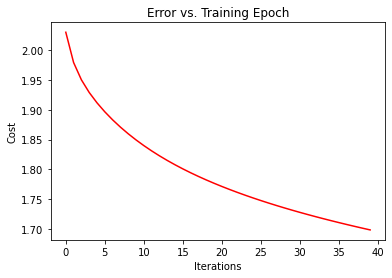

In [1505]:
fig, ax = plt.subplots()  
ax.plot(np.arange(GDparams['n_epochs']), cost, 'r')  
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')